In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams['figure.figsize'] = fig_size
from matplotlib import rc
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import xgboost
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


# Primera fase: Análisis
La fase de análisis se refiere al proceso crítico de realizar investigaciones iniciales sobre datos para descubrir patrones, detectar anomalías, probar hipótesis y verificar supuestos con la ayuda de estadísticas y representaciones gráficas. Nuestro objetivo es predecir el precio de inmuebles, dependiendo de todas las otras variables. El precio, en este caso, es nuestra variable dependiente, mientras que todas las demás características son variables independientes. 

## Obtención de datos de viviendas 
  El conjunto de datos utilizado en este proyecto proviene del dataset publicado en kaggle.com, llamado "House Sales in King County, USA". Este conjunto de datos contiene precios de venta de viviendas para el condado de King, que incluye Seattle, en Estados Unidos. Incluye casas vendidas entre mayo de 2014 y mayo de 2015.

In [2]:
df = pd.read_csv('Dataset/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Limpieza y análisis exploratorio inicial de los datos obtenidos
Después de haber recopilado toda la información, se analizarán y evaluarán los datos obtenidos para lograr elegir un subgrupo de datos para poder resolver el problema definido.

In [3]:
df.shape

(21613, 21)

In [4]:
#Tabla con los precios del dataset
precios = df['price']
precios.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [5]:
#Precio mínimo en el dataset
min_precio = np.amin(precios)
#Precio máximo en el dataset
max_precio = np.amax(precios)
#Media del precio en el dataset
media_precio = np.mean(precios)
#Mediana del precio en el dataset
mediana_precio = np.median(precios)
#Desviación estándar del precio en el dataset
std_precio = np.std(precios)

#Resultados
print("Resultados:")
print("Precio mínimo: ${}".format(min_precio))
print("Precio máximo: ${}".format(max_precio))
print("Media: ${}".format(media_precio))
print("Mediana: ${}".format(mediana_precio))
print("Desviación Estándar: ${}".format(std_precio))

Resultados:
Precio mínimo: $75000.0
Precio máximo: $7700000.0
Media: $540088.1417665294
Mediana: $450000.0
Desviación Estándar: $367118.7031813722


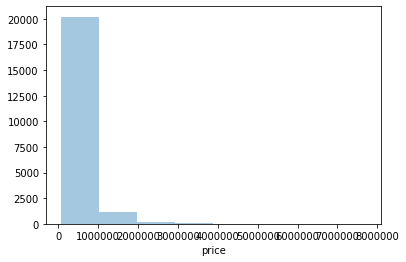

In [6]:
#Distribución del precio
sns.distplot(df['price'], kde=False, bins=8)

### Correlacion entre las variables y precio
Tener demasiadas funciones en un modelo no siempre es algo bueno porque puede causar un sobreajuste y resultados peores cuando queremos predecir valores para un nuevo conjunto de datos. Por lo tanto, si una característica no mejora mucho su modelo, no agregarlo puede ser una mejor opción.

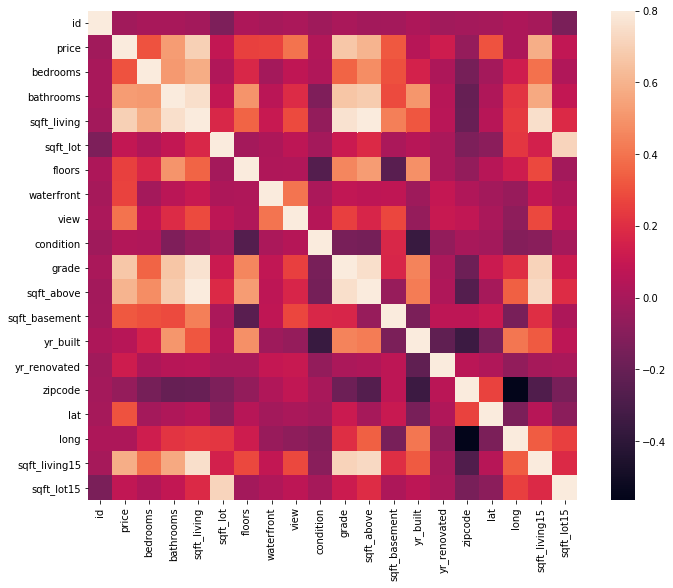

In [7]:
#Matriz de correlacion
matcorr = df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(matcorr, vmax = .8, square = True)

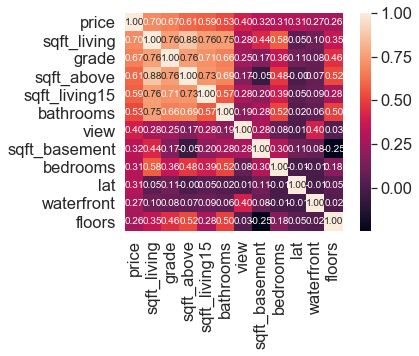

In [8]:
#Primeras 12 variables mas correlacionadas
n = 12 #numero de variables a utilizar para la matriz
col = matcorr.nlargest(n, 'price')['price'].index
cm = np.corrcoef(df[col].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = col.values, xticklabels = col.values)
plt.show()

In [9]:
#Tabla con las variables mas correlacionadas con precio
mas_corr = pd.DataFrame(col)
mas_corr.columns = ['Variables mas correlacionadas']
mas_corr

,Variables mas correlacionadas
0,price
1,sqft_living
2,grade
3,sqft_above
4,sqft_living15
5,bathrooms
6,view
7,sqft_basement
8,bedrooms
9,lat


## 	Consolidación del dataset final para pruebas
Para el propósito del proyecto, el conjunto de datos se ha preprocesado de la siguiente manera:

In [10]:
#Buscando valores nulos en el dataset
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [11]:
#Dataset final a utilizar, con las 12 caracteristicas mas correlacionadas
dataset = df.copy().drop(['id', 'floors', 'date', 'sqft_lot', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'condition'], axis = 1)
dataset.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_basement,yr_built,lat,sqft_living15
0,221900.0,3,1.00,1180,0,0,7,1180,0,1955,47.5112,1340
1,538000.0,3,2.25,2570,0,0,7,2170,400,1951,47.7210,1690
2,180000.0,2,1.00,770,0,0,6,770,0,1933,47.7379,2720
3,604000.0,4,3.00,1960,0,0,7,1050,910,1965,47.5208,1360
4,510000.0,3,2.00,1680,0,0,8,1680,0,1987,47.6168,1800


## Análisis exploratorio exhaustivo del dataset final
Veremos y analizaremos las relaciones existentes entre el precio y las demás características de nuestro conjunto de datos final.

### Gráficos de dispersión

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


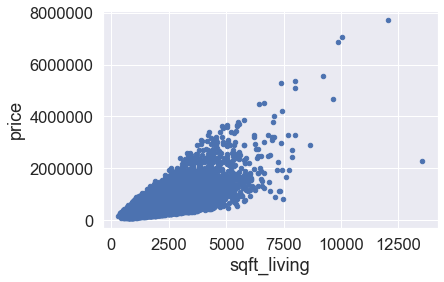

In [12]:
#Sqft_living vs precio
dataset.plot.scatter('sqft_living', 'price')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


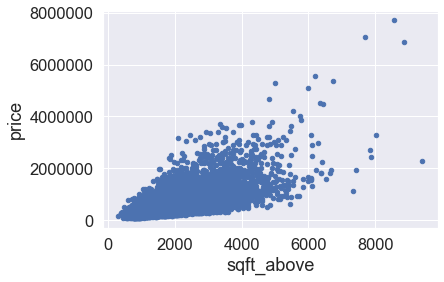

In [13]:
#Sqft_above vs precio
dataset.plot.scatter('sqft_above', 'price')

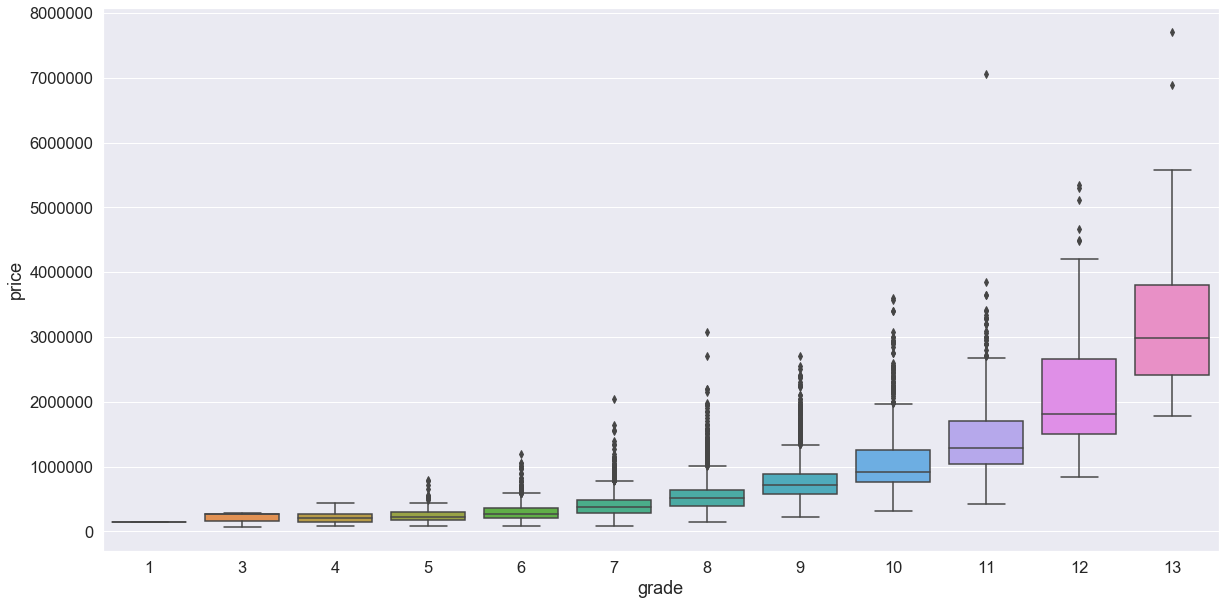

In [14]:
#Calificacion vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['grade'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


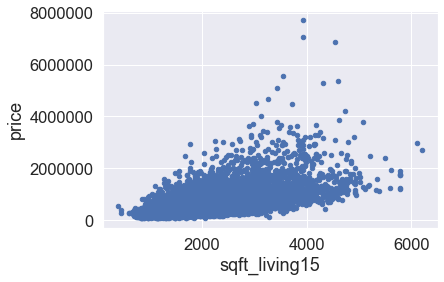

In [15]:
#Sqft_living15 vs precio
dataset.plot.scatter('sqft_living15', 'price')

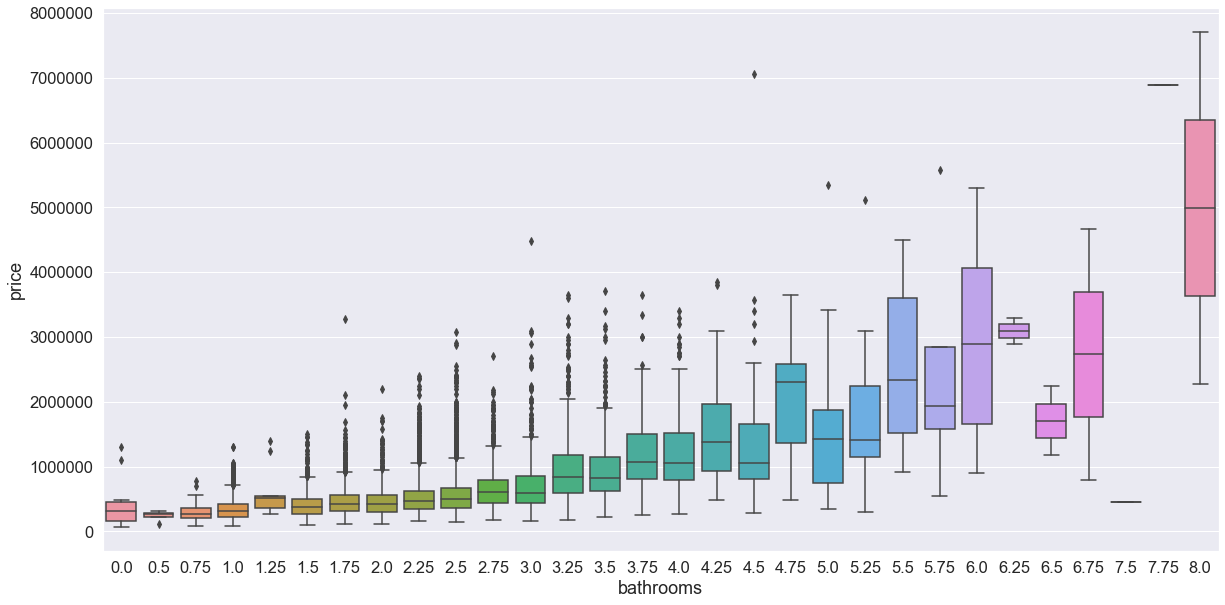

In [16]:
#Baños vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bathrooms'], y=dataset['price'])

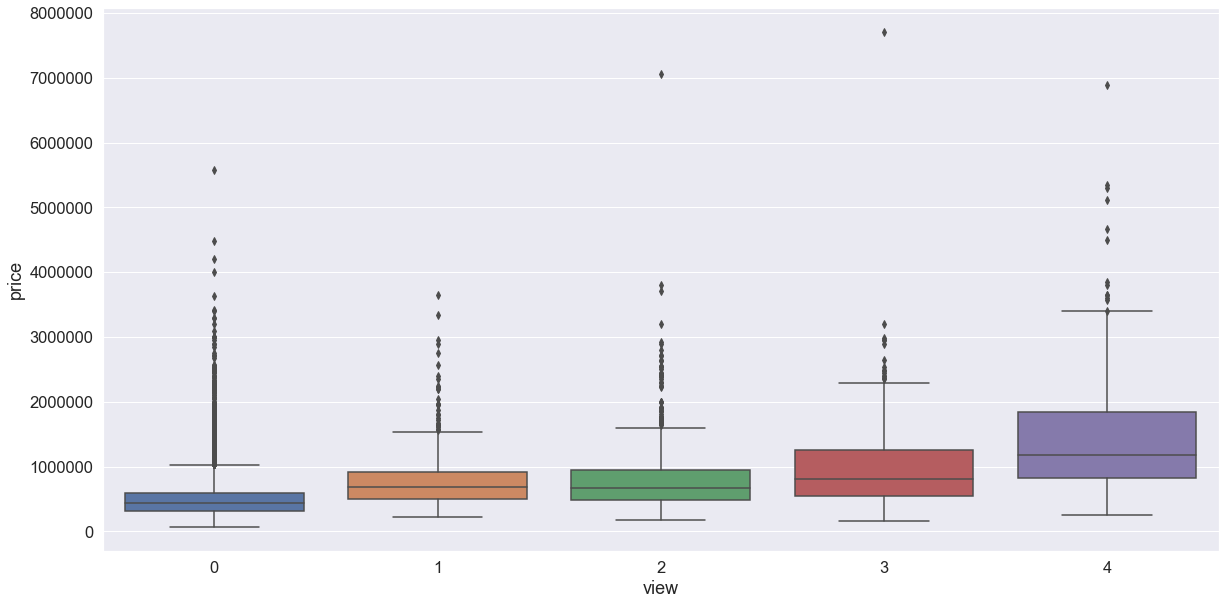

In [17]:
#Vista vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['view'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


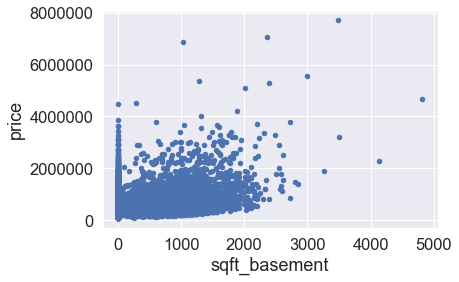

In [18]:
#Sqft_basement vs precio
dataset.plot.scatter('sqft_basement', 'price')

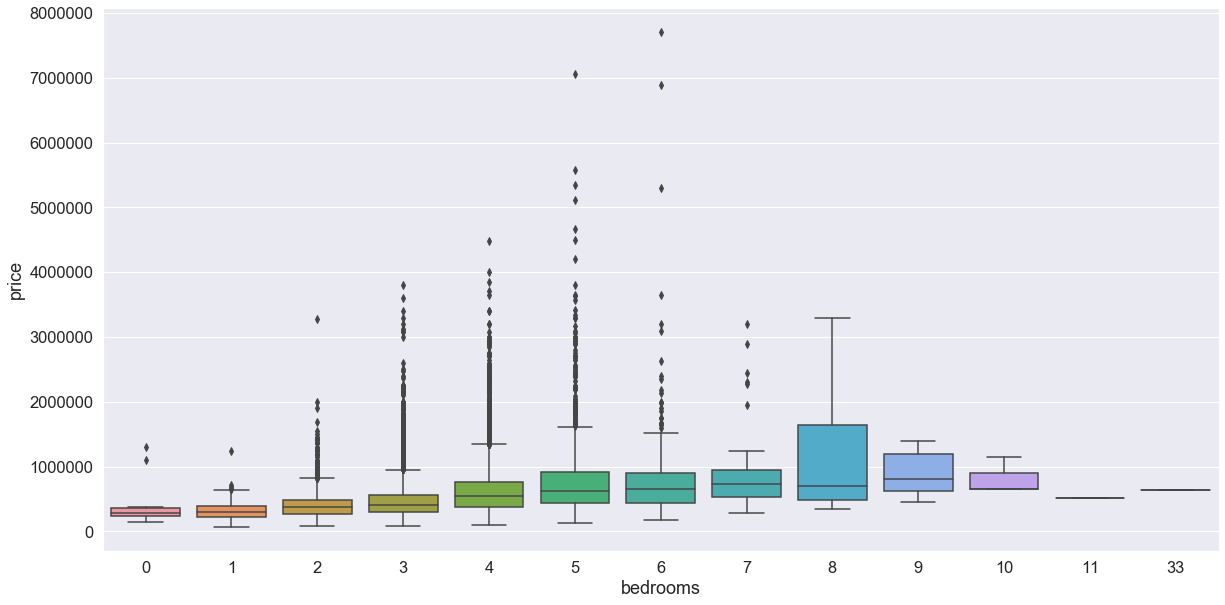

In [20]:
#Habitaciones vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bedrooms'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


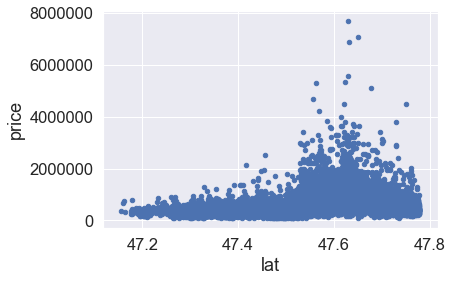

In [26]:
#Latitud vs precio
dataset.plot.scatter('lat', 'price')

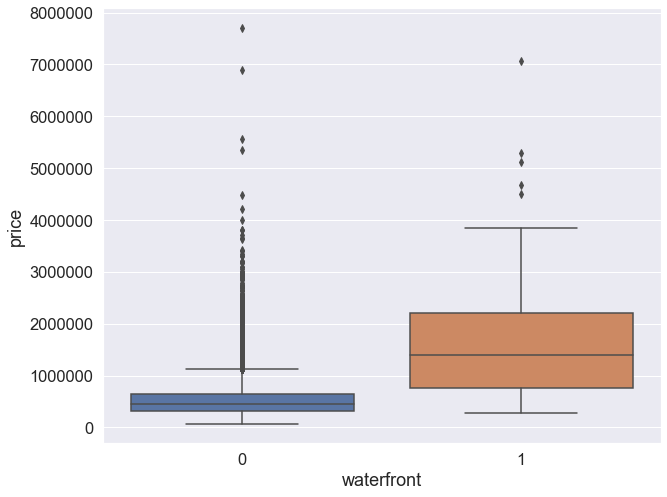

In [21]:
#Frente al mar vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['waterfront'], y=dataset['price'])

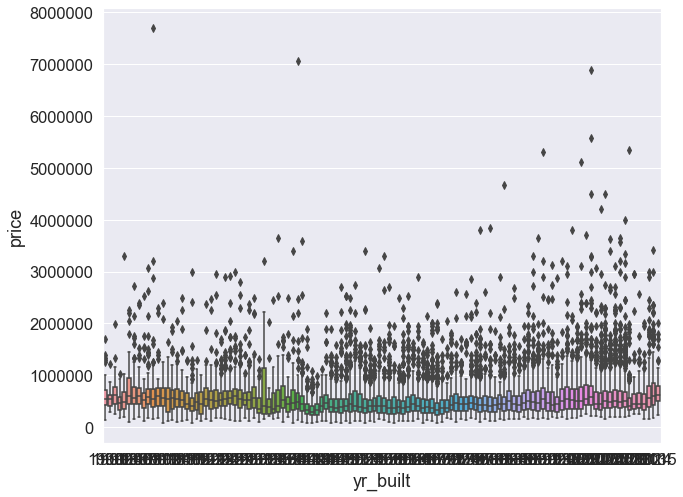

In [22]:
#Año de construcción vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['yr_built'], y=dataset['price'])

# Fase 2: Diseño

## Elaboración de hipótesis de trabajo en base del estudio exploratorio previo.

## Procesamiento de información y generación de características para modelado.

### División de los datos
Para esta sección tomaremos el conjunto de datos de vivienda y los dividiremos en subconjuntos de entrenamiento y evaluación. Por lo general, los datos también se mezclan en un orden aleatorio al crear los subconjuntos de entrenamiento y prueba para eliminar cualquier sesgo en el orden del conjunto de datos.

In [23]:
#Tabla que contiene las caracteristicas de los inmuebles, sin la variable dependiente, precio, la cual intentaremos predecir
carac = dataset.drop(['price'], axis = 1)
carac.head()

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_basement,yr_built,lat,sqft_living15
0,3,1.00,1180,0,0,7,1180,0,1955,47.5112,1340
1,3,2.25,2570,0,0,7,2170,400,1951,47.7210,1690
2,2,1.00,770,0,0,6,770,0,1933,47.7379,2720
3,4,3.00,1960,0,0,7,1050,910,1965,47.5208,1360
4,3,2.00,1680,0,0,8,1680,0,1987,47.6168,1800


In [27]:
#Tabla que contiene los precios de los inmuebles en el dataset
precios = pd.DataFrame(dataset['price'])
precios.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [28]:
#Division de las variables en entrenamiento y evaluacion
x_ent, x_eval, y_ent, y_eval = train_test_split(carac, precios, test_size=0.2)

# Fase 3: Implementación
En esta tercera sección del proyecto, desarrollaremos las herramientas y técnicas necesarias para que un modelo haga una predicción. 

## Generación de modelos predictivos utilizando machine learning.
Una vez que se limpian los datos, procederemos a realizar nuestros modelos de aprendizaje automático. El precio de venta es en dólares e intentaremos predecirlo.

### Regresión Lineal
En estadísticas, regresión lineal es una aproximación para modelar la relación entre una variable escalar dependiente "Y" y una o mas variables explicativas nombradas con "X". Lo que haremos es "dibujar una recta" que nos indicará la tendencia de un conjunto de datos continuos. 

In [29]:
lr = linear_model.LinearRegression()
modelo_1 = lr.fit(x_ent, y_ent)
print('Coeficientes: ', modelo_1.coef_)
print('Intersección: ', modelo_1.intercept_)

Coeficientes:  [[-3.04410914e+04  4.87465848e+04 -2.02268987e+15  4.97146446e+05
   5.52806624e+04  1.04238409e+05  2.02268987e+15  2.02268987e+15
  -3.01211651e+03  5.60635896e+05  1.80853277e+01]]
Intersección:  [-21380286.00967088]


In [30]:
prediccion_1 = modelo_1.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_1)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_1))
r2 = metrics.r2_score(y_eval, prediccion_1)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 123115.84381316432
Error cuadrático medio: 203849.23204674575
R-cuadrado: 0.7011189311009829


In [31]:
#Tabla que contiene los resultados de las metricas de evaluacion de cada modelo
evaluacion = pd.DataFrame({'Modelo': [], 'Error medio absoluto':[], 'Error cuadrático medio':[], 'R-cuadrado':[],})
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion lineal', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)
evaluacion

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,123115.843813,203849.232047,0.701119


In [32]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_1.flatten()
valor_real = np.array(y_eval).flatten()

In [33]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,359000.0,3.771523e+05
1,356000.0,2.490086e+05
2,355000.0,3.956711e+05
3,479500.0,5.182153e+05
4,1468000.0,1.499108e+06
...,...,...
4318,390000.0,4.902216e+05
4319,601000.0,4.988452e+05
4320,235000.0,1.942320e+05
4321,360000.0,2.760652e+05


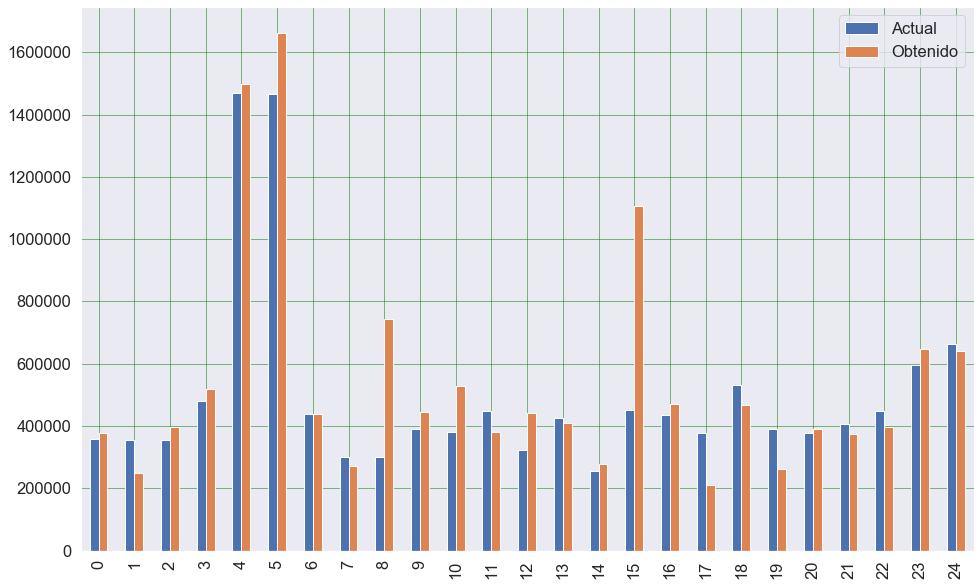

In [34]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Cross Validation y RFE
La validación cruzada (Cross Validation en ingles) es una técnica utilizada para evaluar modelos de ML mediante la capacitación de varios modelos en subconjuntos de datos de entrada disponibles y evaluándolos en el subconjunto complementario de datos, consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes las particiones.
RFE o Eliminación de Características Recursivas consiste en la selección de características automáticamente de los datos que más contribuyen a la variable de predicción. Tener características irrelevantes en los datos puede disminuir la precisión de muchos modelos, especialmente los algoritmos lineales como la regresión lineal y logística.

#### RFE con 3 caracteristicas a elegir

In [35]:
#RFE
lr = linear_model.LinearRegression()
rfe = RFE(lr, n_features_to_select=3)

In [36]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe.fit(X, Y)

In [37]:
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False  True False False False  True False]
[4 3 6 1 2 1 7 8 5 1 9]


In [38]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'sqft_living'), (1, 'view'), (1, 'yr_built'), (2, 'waterfront'), (3, 'bedrooms'), (4, 'price'), (5, 'sqft_basement'), (6, 'bathrooms'), (7, 'grade'), (8, 'sqft_above'), (9, 'lat')]


In [39]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe.transform(X)
nueva_x

array([[ 0.    ,  7.    , 47.5112],
       [ 0.    ,  7.    , 47.721 ],
       [ 0.    ,  6.    , 47.7379],
       ...,
       [ 0.    ,  7.    , 47.5944],
       [ 0.    ,  8.    , 47.5345],
       [ 0.    ,  7.    , 47.5941]])

In [40]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_2 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21608 21610 21611]
Division de evaluacion:  [    5     6     8 ... 21601 21609 21612]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [   13    25    28 ... 21596 21603 21604]
Division de entrenamiento:  [    0     2     3 ... 21610 21611 21612]
Division de evaluacion:  [    1    10    12 ... 21599 21602 21608]
Division de entrenamiento:  [    0     1     5 ... 21610 21611 21612]
Division de evaluacion:  [    2     3     4 ... 21598 21606 21607]
Division de entrenamiento:  [    1     2     3 ... 21608 21609 21612]
Division de evaluacion:  [    0     7    14 ... 21605 21610 21611]


In [41]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.5526151540343212, 0.5459985172884874, 0.5212568256275345, 0.5514207947154862, 0.5610932776587305]
Promedio de las puntaciones 0.5464769138649119


In [42]:
prediccion_2 = modelo_2.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_2)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_2))
r2 = metrics.r2_score(Y_eval, prediccion_2)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 157139.5486991291
Error cuadrático medio: 250054.83679445274
R-cuadrado: 0.5610932776587305


In [43]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (3)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,123115.843813,203849.232047,0.701119
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [44]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_2.flatten()
valor_real = np.array(Y_eval).flatten()

In [45]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,221900.0,375641.041665
1,291850.0,311398.118079
2,530000.0,475953.492652
3,329000.0,482662.351822
4,687500.0,483723.285770
...,...,...
4317,350000.0,483294.042320
4318,1575000.0,991072.743925
4319,610685.0,764725.098809
4320,402101.0,428197.691048


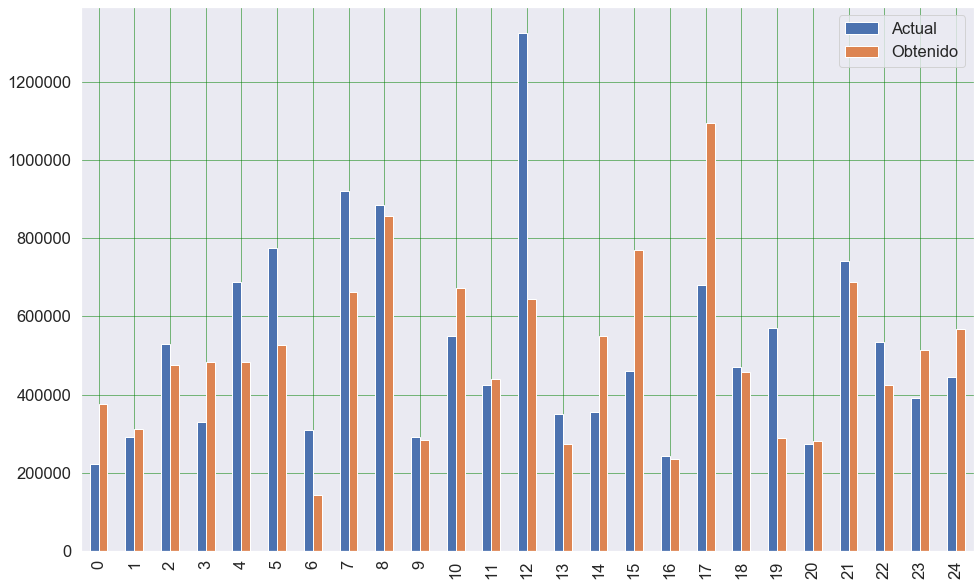

In [46]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### RFE con 5 caracteristicas a elegir

In [47]:
#RFE
lr = linear_model.LinearRegression()
rfe_2 = RFE(lr, n_features_to_select=5)

In [48]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_2.fit(X, Y)

In [49]:
print(rfe_2.support_)
print(rfe_2.ranking_)

[False  True False  True  True  True False False False  True False]
[2 1 4 1 1 1 5 6 3 1 7]


In [50]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_2.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'bedrooms'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'price'), (3, 'sqft_basement'), (4, 'bathrooms'), (5, 'grade'), (6, 'sqft_above'), (7, 'lat')]


In [51]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_2.transform(X)
nueva_x

array([[ 1.    ,  0.    ,  0.    ,  7.    , 47.5112],
       [ 2.25  ,  0.    ,  0.    ,  7.    , 47.721 ],
       [ 1.    ,  0.    ,  0.    ,  6.    , 47.7379],
       ...,
       [ 0.75  ,  0.    ,  0.    ,  7.    , 47.5944],
       [ 2.5   ,  0.    ,  0.    ,  8.    , 47.5345],
       [ 0.75  ,  0.    ,  0.    ,  7.    , 47.5941]])

In [52]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_3 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21609 21611 21612]
Division de evaluacion:  [    9    11    12 ... 21594 21598 21610]
Division de entrenamiento:  [    0     1     2 ... 21607 21608 21610]
Division de evaluacion:  [   13    19    23 ... 21609 21611 21612]
Division de entrenamiento:  [    2     3     6 ... 21610 21611 21612]
Division de evaluacion:  [    0     1     4 ... 21597 21606 21608]
Division de entrenamiento:  [    0     1     3 ... 21610 21611 21612]
Division de evaluacion:  [    2     6    15 ... 21587 21590 21607]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    3     7     8 ... 21596 21600 21602]


In [53]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.5811437908042703, 0.5548077549046142, 0.6204816657370935, 0.5820046760677847, 0.6056587282942917]
Promedio de las puntaciones 0.5888193231616109


In [54]:
prediccion_3 = modelo_3.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_3)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_3))
r2 = metrics.r2_score(Y_eval, prediccion_3)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 145352.3637079883
Error cuadrático medio: 222303.93890429163
R-cuadrado: 0.6056587282942917


In [55]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (5)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,123115.843813,203849.232047,0.701119
2,RFE con Cross Validation (5),145352.363708,222303.938904,0.605659
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [56]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_3.flatten()
valor_real = np.array(Y_eval).flatten()

In [57]:
#Tabla de comparacion, contiendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,604000.0,4.632034e+05
1,291850.0,2.675095e+05
2,229500.0,2.959511e+05
3,662500.0,6.220818e+05
4,395000.0,5.209568e+05
...,...,...
4317,270000.0,2.976705e+05
4318,475000.0,6.377086e+05
4319,679950.0,7.087029e+05
4320,1537000.0,1.181392e+06


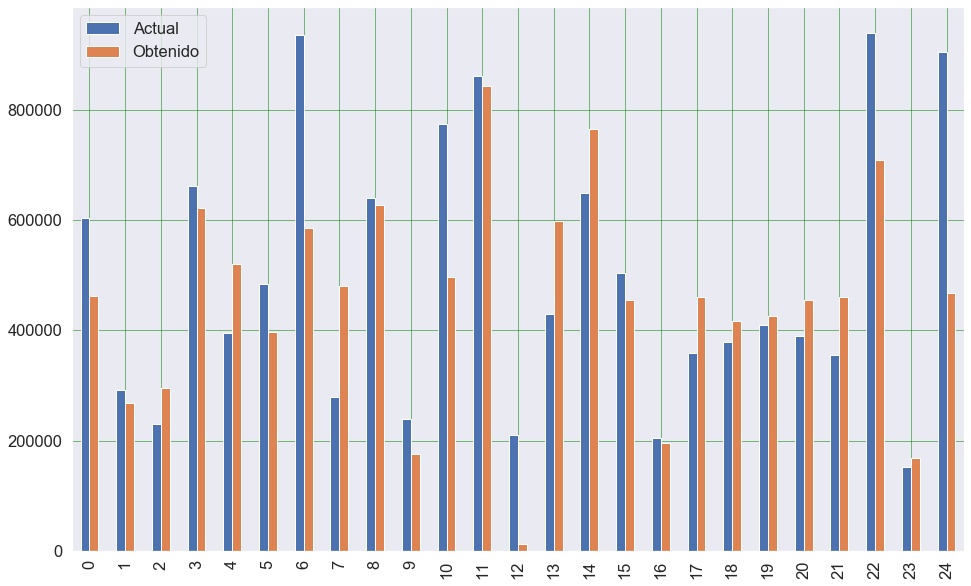

In [58]:
#Ahora graficaremos la diferencia observada entre cihos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### RFE con 7 caracteristicas a elegir

In [59]:
#RFE
lr = linear_model.LinearRegression()
rfe_3 = RFE(lr, n_features_to_select=7)

In [60]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_3.fit(X, Y)

In [61]:
print(rfe_3.support_)
print(rfe_3.ranking_)

[ True  True False  True  True  True False False  True  True False]
[1 1 2 1 1 1 3 4 1 1 5]


In [62]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_3.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'bedrooms'), (1, 'price'), (1, 'sqft_basement'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'bathrooms'), (3, 'grade'), (4, 'sqft_above'), (5, 'lat')]


In [63]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_3.transform(X)
nueva_x

array([[3.00000e+00, 1.00000e+00, 0.00000e+00, ..., 7.00000e+00,
        1.95500e+03, 4.75112e+01],
       [3.00000e+00, 2.25000e+00, 0.00000e+00, ..., 7.00000e+00,
        1.95100e+03, 4.77210e+01],
       [2.00000e+00, 1.00000e+00, 0.00000e+00, ..., 6.00000e+00,
        1.93300e+03, 4.77379e+01],
       ...,
       [2.00000e+00, 7.50000e-01, 0.00000e+00, ..., 7.00000e+00,
        2.00900e+03, 4.75944e+01],
       [3.00000e+00, 2.50000e+00, 0.00000e+00, ..., 8.00000e+00,
        2.00400e+03, 4.75345e+01],
       [2.00000e+00, 7.50000e-01, 0.00000e+00, ..., 7.00000e+00,
        2.00800e+03, 4.75941e+01]])

In [64]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_4 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     2     3 ... 21608 21610 21611]
Division de evaluacion:  [    1     6    11 ... 21598 21609 21612]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [   12    13    25 ... 21604 21606 21608]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [   10    17    26 ... 21591 21597 21603]
Division de entrenamiento:  [    1     5     6 ... 21610 21611 21612]
Division de evaluacion:  [    0     2     3 ... 21601 21602 21607]
Division de entrenamiento:  [    0     1     2 ... 21608 21609 21612]
Division de evaluacion:  [    5     8    15 ... 21605 21610 21611]


In [65]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.6565754851979219, 0.6298281007331735, 0.6369912008951486, 0.6483572974478422, 0.6409198161259378]
Promedio de las puntaciones 0.6425343800800049


In [66]:
prediccion_4 = modelo_4.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_4)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_4))
r2 = metrics.r2_score(Y_eval, prediccion_4)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 134962.08805324908
Error cuadrático medio: 215670.3783469009
R-cuadrado: 0.6409198161259378


In [67]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (7)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,123115.843813,203849.232047,0.701119
3,RFE con Cross Validation (7),134962.088053,215670.378347,0.640920
2,RFE con Cross Validation (5),145352.363708,222303.938904,0.605659
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [68]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_4.flatten()
valor_real = np.array(Y_eval).flatten()

In [69]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,1225000.0,1.330935e+06
1,229500.0,2.852283e+05
2,650000.0,1.028358e+06
3,230000.0,1.611579e+05
4,385000.0,5.258245e+05
...,...,...
4317,350000.0,4.331588e+05
4318,1537000.0,1.210964e+06
4319,610685.0,6.270363e+05
4320,402101.0,1.188898e+05


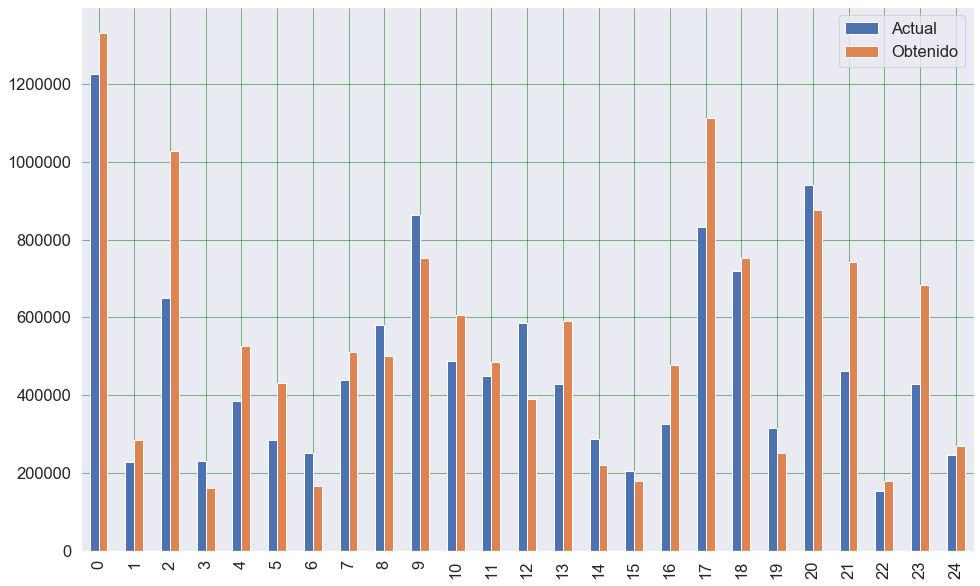

In [70]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Gradient Boosting
Gradient boosting o Potenciación del gradiente, es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Puede ser interpretado como un algoritmo de optimización en una función de coste adecuada

In [71]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [72]:
xgb.fit(x_ent,y_ent)

[12:12:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [73]:
prediccion_5 = xgb.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_5)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_5))
r2 = metrics.r2_score(y_eval, prediccion_5)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 82175.48206540597
Error cuadrático medio: 147907.39209171993
R-cuadrado: 0.8426524418237623


In [74]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['XGBoost', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
4,XGBoost,82175.482065,147907.392092,0.842652
0,Regresion lineal,123115.843813,203849.232047,0.701119
3,RFE con Cross Validation (7),134962.088053,215670.378347,0.640920
2,RFE con Cross Validation (5),145352.363708,222303.938904,0.605659
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [75]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_5.flatten()
valor_real = np.array(y_eval).flatten()

In [76]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelos
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,359000.0,3.817721e+05
1,356000.0,3.282915e+05
2,355000.0,3.121684e+05
3,479500.0,5.002329e+05
4,1468000.0,1.848775e+06
...,...,...
4318,390000.0,5.977441e+05
4319,601000.0,5.968522e+05
4320,235000.0,2.434638e+05
4321,360000.0,4.461913e+05


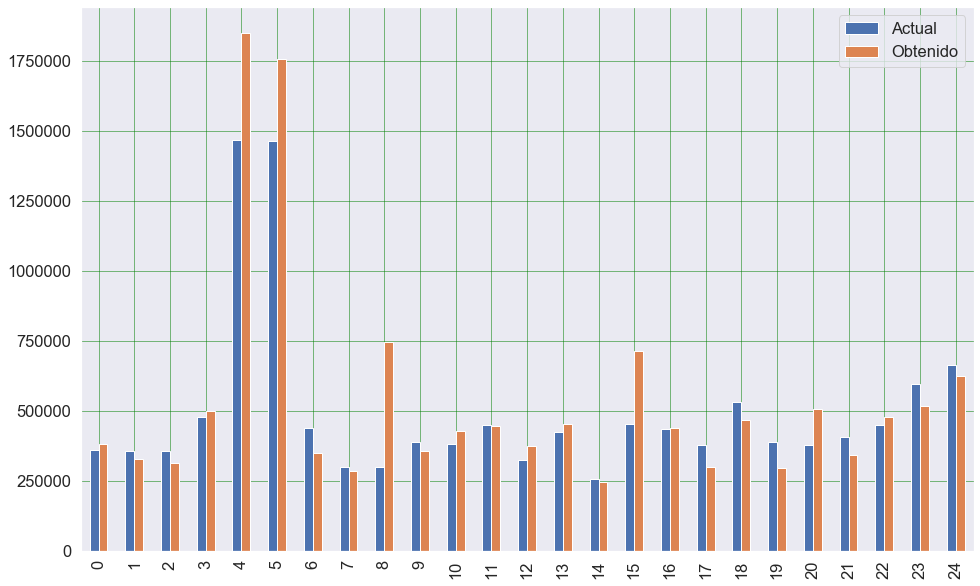

In [77]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Regresion Polinomial
Polynomial Regression is a form of linear regression in which the relationship between the independent variable x and dependent variable y is modeled as an nth degree polynomial.

In [79]:
poly = PolynomialFeatures(degree=2)
X_entp = poly.fit_transform(x_ent)
X_evalp = poly.fit_transform(x_eval)
lr = linear_model.LinearRegression().fit(X_entp, y_ent)

In [80]:
prediccion_6 = lr.predict(X_evalp)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_6)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_6))
r2 = metrics.r2_score(y_eval, prediccion_6)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 104968.59144657716
Error cuadrático medio: 168129.62570914245
R-cuadrado: 0.7966853184238982


In [81]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion Polinomial', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
4,XGBoost,82175.482065,147907.392092,0.842652
5,Regresion Polinomial,104968.591447,168129.625709,0.796685
0,Regresion lineal,123115.843813,203849.232047,0.701119
3,RFE con Cross Validation (7),134962.088053,215670.378347,0.640920
2,RFE con Cross Validation (5),145352.363708,222303.938904,0.605659
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [82]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_6.flatten()
valor_real = np.array(y_eval).flatten()

In [83]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,359000.0,4.710425e+05
1,356000.0,3.775727e+05
2,355000.0,4.076136e+05
3,479500.0,5.072291e+05
4,1468000.0,1.666090e+06
...,...,...
4318,390000.0,3.759009e+05
4319,601000.0,5.216731e+05
4320,235000.0,3.304691e+05
4321,360000.0,3.510906e+05


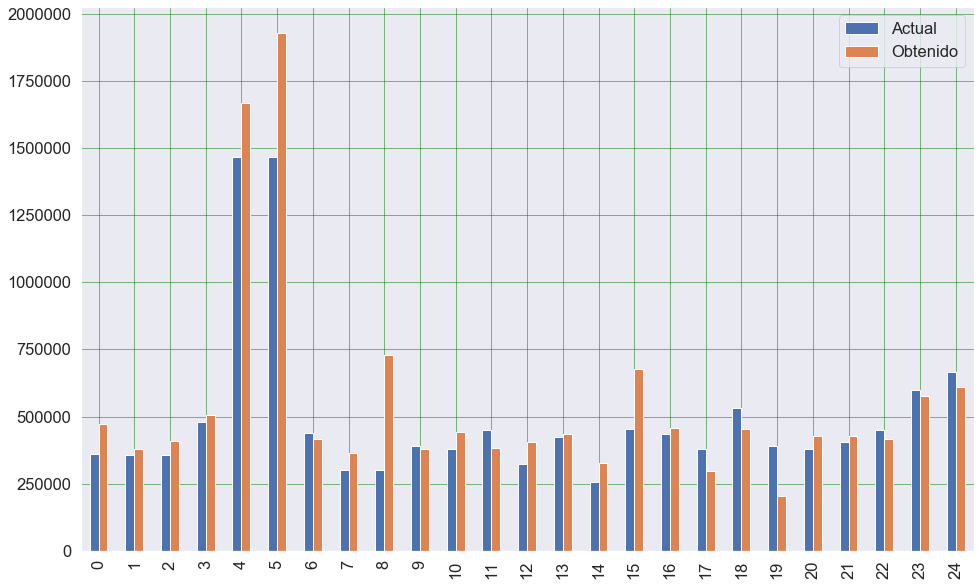

In [84]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Random Forest Regressor
Los bosques aleatorios o los bosques de decisión aleatorios son un método de aprendizaje para la clasificación, la regresión y otras tareas que operan construyendo una multitud de árboles de decisión en el momento del entrenamiento y generan asi la predicción media (regresión) de los árboles individuales. Los bosques de decisión aleatorios corrigen el hábito de los árboles de decisión de adaptarse demasiado a su conjunto de entrenamiento.

In [85]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
regressor.fit(x_ent, y_ent) 

C:\Users\mavil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [86]:
prediccion_7 = regressor.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_7)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_7))
r2 = metrics.r2_score(y_eval, prediccion_7)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 81414.26918788577
Error cuadrático medio: 146873.05797630665
R-cuadrado: 0.844845447598031


In [87]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Bosques Aleatorios', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
6,Bosques Aleatorios,81414.269188,146873.057976,0.844845
4,XGBoost,82175.482065,147907.392092,0.842652
5,Regresion Polinomial,104968.591447,168129.625709,0.796685
0,Regresion lineal,123115.843813,203849.232047,0.701119
3,RFE con Cross Validation (7),134962.088053,215670.378347,0.640920
2,RFE con Cross Validation (5),145352.363708,222303.938904,0.605659
1,RFE con Cross Validation (3),157139.548699,250054.836794,0.561093


In [88]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_7.flatten()
valor_real = np.array(y_eval).flatten()

In [89]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,359000.0,379416.66
1,356000.0,324243.94
2,355000.0,277464.50
3,479500.0,530170.00
4,1468000.0,1775864.00
...,...,...
4318,390000.0,631247.75
4319,601000.0,588310.14
4320,235000.0,242744.50
4321,360000.0,396642.25


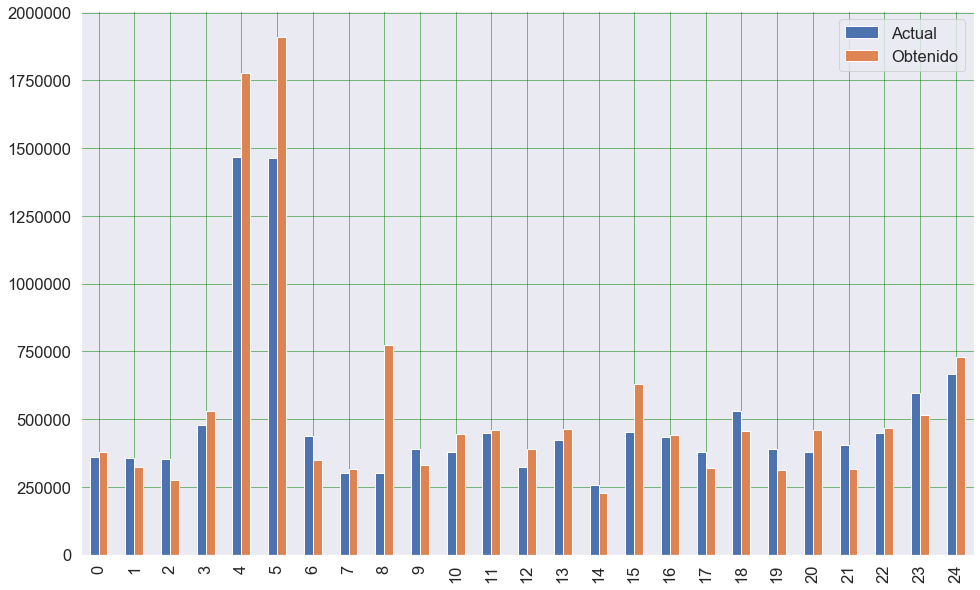

In [90]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()